In [1]:
# imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

import os
from utils.basic_utils import *
from utils.pricing import discret_rets, sample_wgts, dummy_col, rename_col
from utils.fundamental import pipe_transform_df, chain_divide, chain_scale
from utils.fundamental import chain_outlier, chain_post_drop, chain_wide_transform
from utils.fundamental import chain_eps_estimates, chain_eps_revisions, chain_rec_trend
from utils.fundamental import load_append_ds, get_daily_ts, numeric_cols, filter_cols
from utils.ml_utils import show_fi, print_cv_results

from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.validation import column_or_1d
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, log_loss, precision_recall_fscore_support
from sklearn.metrics import precision_score, roc_auc_score

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.externals import joblib

pd.options.display.float_format = '{:,.2f}'.format

Loading utils/config.json


In [25]:
key = 'eps_trend'
pre = key.split('_')[0] # append preffix

# environment variables
cuts = { '1d': [-1, -0.1, -.02, .02, .1, 1.] }
cut_range = cuts['1d']
fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]
look_ahead, look_back = 20, 252
y_col = 'fwdReturn' + f'{look_ahead}'

In [18]:
# feature mapping for different datasets
ds_dict = {
    'fin_data': {
        'path': 'summary-categories/financialData/',
        'index': 'storeDate',
        'features': [
            'numberOfAnalystOpinions', 'currentPrice', 'revenuePerShare', 'totalCashPerShare',
            'currentRatio', 'debtToEquity', 'earningsGrowth', 'ebitda', 
            'ebitdaMargins', 'freeCashflow', 'grossMargins', 
            'grossProfits', 'operatingCashflow', 'operatingMargins', 'profitMargins', 
            'quickRatio', 'recommendationMean', 
            'returnOnAssets', 'returnOnEquity', 'revenueGrowth', 
            'targetHighPrice', 'targetLowPrice', 'targetMeanPrice', 
            'targetMedianPrice', 'totalCash', 'totalDebt', 'totalRevenue', 
#             'financialCurrency', 'recommendationKey',              
            'symbol', ],
        'scale': [
            'freeCashflow', 'operatingCashflow', 'ebitda', 
            'totalCash', 'totalDebt', 'totalRevenue', 'grossProfits', ],
        'divide': ('currentPrice', 
                   ['revenuePerShare', 'totalCashPerShare', 
                    'targetLowPrice', 'targetMeanPrice', 
                    'targetMedianPrice', 'targetHighPrice', ]),
        'outlier': 10,
        'post_drop': ['numberOfAnalystOpinions'],
    },    
    'key_statistics': {
        'path': 'summary-categories/defaultKeyStatistics/',
        'index': 'storeDate',
        'features': [
            'beta', 'earningsQuarterlyGrowth', 
            'enterpriseToEbitda', 'enterpriseToRevenue', 'enterpriseValue', 'forwardPE', 
            'netIncomeToCommon', 'pegRatio', 'priceToBook', 'profitMargins', 
            'shortPercentOfFloat', 'shortRatio', 'heldPercentInsiders', 
            'heldPercentInstitutions', 'symbol', ],
        'scale': ['enterpriseValue', 'netIncomeToCommon', ],
        'outlier': 10, 
    },
    'eps_trend': {
        'path': 'summary-categories/epsTrend/',
        'index': 'storeDate',
        'periods': ['0y', '+1y', '+5y', '-5y'],        
        'features': [
            'period', 'growth', 
            'current', '7daysAgo', '30daysAgo', '60daysAgo', '90daysAgo', 
            'symbol', ],
        'pivot_cols': ['growth', 'current', '7daysAgo', '30daysAgo', '60daysAgo', '90daysAgo'],
        'outlier': 3,
    },
    'eps_estimates': {
        'path': 'summary-categories/earningsEstimate/',
        'index': 'storeDate',
        'periods': ['0y', '+1y', '+5y', '-5y'],
        'features': [
            'period', 'growth', 'avg', 'low', 'high', 'symbol', ],
        'pivot_cols': ['growth', 'avg', 'low', 'high'],
        'outlier': 6 
    },
    'day_quote': {
        'path': 'quote/csv/',
        'index': 'storeDate',
        'features': [
            'regularMarketChangePercent',
            'averageDailyVolume10Day', 'averageDailyVolume3Month', 'regularMarketVolume', 
            'fiftyDayAverageChangePercent', 'twoHundredDayAverageChangePercent',
            'fiftyTwoWeekHighChangePercent', 'fiftyTwoWeekLowChangePercent', 
            'forwardPE', 'trailingPE', 'priceToBook', 'marketCap', 'symbol', ],
        'scale': ['marketCap', ],
        'divide': ('regularMarketVolume', ['averageDailyVolume10Day', 'averageDailyVolume3Month']),
        'outlier': 10, 
    },    
    'eps_revisions': {
        'path': 'summary-categories/epsRevisions/',
        'index': 'storeDate',
        'periods': ['0y', '+1y', '+5y', '-5y'],
        'features': [
            'period', 'growth', 'upLast7days', 'upLast30days', 'downLast30days', 
            'symbol', ],
        'pivot_cols': ['growth', 'upLast7days', 'upLast30days', 'downLast30days'],
        'outlier': 3, 
    },
    'spy_trend': {
        'path': 'summary-categories/indexTrend/',
        'index': 'storeDate',
        'features': [
            '0q', '+1q', '0y', '+1y', '+5y', '-5y', 
            'peRatio', 'pegRatio', 'symbol', ]
    },
    'net_purchase': {
        'path': 'summary-categories/netSharePurchaseActivity/',
        'index': 'storeDate',
        'features': [
            'netPercentInsiderShares', 'buyPercentInsiderShares', 'sellPercentInsiderShares', 
            'symbol', ]
    },    
    'rec_trend': {
        'path': 'summary-categories/recommendationTrend/',
        'index': 'storeDate',
        'periods': ['-1m', '-2m'],
        'features': [
            'period', 'strongBuy', 'buy', 'hold', 'sell', 'strongSell', 
            'symbol', ],
        'pivot_cols': ['strongBuy', 'buy', 'hold', 'sell', 'strongSell'],
        'outlier': 10,
    },
}

In [19]:
# loads context data
symbols_list = config['companies']
# px_close = get_mults_pricing(symbols_list)

# last saved pricing from local drive
px_close = pd.read_parquet('tmp/mult-co-px-ds')
px_close.index = px_close.index.date
print(px_close.info())

Y = px_close.pct_change(look_ahead).shift(-look_ahead)
Y = Y[~(Y.isna().all(1))]

# use the latest saved data for profile and quote info
dates = read_dates('quote')
tgt_date = dates[-1:] # last date saved in S3

quotes = load_csvs('quote_consol', tgt_date)
quotes.set_index('symbol', drop=False, inplace=True)

profile = load_csvs('summary_detail', ['assetProfile'])
profile.set_index('symbol', drop=False, inplace=True)

stacked_px = px_close.stack().to_frame().rename(columns={0: 'close'})
stacked_px.index.set_names(['storeDate', 'symbol'], inplace=True)

# load analysts recommendation context data
# find_data = load_append_ds('fin_data', load_dates, ds_dict, ds_append_path)
# find_data.index.name = ds_dict['fin_data']['index']
# stacked_anr = find_data.reset_index().set_index(['storeDate', 'symbol']).numberOfAnalystOpinions

<class 'pandas.core.frame.DataFrame'>
Index: 3774 entries, 2004-04-05 to 2019-04-02
Columns: 1230 entries, REG to BGNE
dtypes: float64(1230)
memory usage: 35.4+ MB
None
Loading file quote/csv/2019-04-02
Loading file summary-categories/assetProfile


In [26]:
# pre-processing pipeline
fn_pipeline = {
    'fin_data': [chain_scale, chain_divide, chain_post_drop, chain_outlier],
    'key_statistics': [chain_scale, chain_outlier],
    'eps_trend': [chain_wide_transform, chain_eps_estimates, chain_outlier],
    'eps_estimates': [chain_wide_transform, chain_eps_estimates, chain_outlier],    
    'day_quote': [chain_divide, chain_scale, chain_outlier],
#     'eps_revisions': [chain_wide_transform, chain_outlier],
#     'spy_trend':[lambda x, y: x],
#     'net_purchase':[lambda x, y: x],    
#     'rec_trend': [chain_wide_transform, chain_rec_trend, chain_outlier],
}

dates = read_dates(ds_dict[key]['path'], '.csv')
load_dates = dates[-look_back:]

context = {    
    'key': key,
    'load_dates': load_dates,    
    'fn_pipeline': fn_pipeline,
    'load_ds': True,
    'grid_search': False,
    'tickers': symbols_list,
    'ds_dict': ds_dict[key],
    'pre': pre,
    'close_px': stacked_px,
    # 'nbr_anr': stacked_anr,
    'ml_path': ('../ML/', 'fdmn_ML-{}_{}.pkl'),
    'ds_append_path': ('tmp/','fund-ml-processed-'),
    'trained_cols': ('fdmn-{}_train_cols.npy'),
    'impute': False,
    'scale': True,
    'verbose': 0,
    's3_path': f'recommend/fdmn_ML-{key}/',
}

### Final

In [6]:
def create_ds(context):
    print('create_ds')
    # context variables
    key = context['key']
    load_ds = context['load_ds']
    load_dates = context['load_dates']
    (path, _) = context['ds_append_path']
    tickers = context['tickers']
    
    # Load or append missing data to local dataset
    fname = path + key
    if load_ds & os.path.isfile(fname):
        daily_df = pd.read_parquet(fname)
        # compare and load missing dates
        missing_dates = list(
            set(daily_df.index.unique().date.astype(str))\
                .symmetric_difference(load_dates))
        if len(missing_dates) > 0: # retrieve missing dates
            append_df = get_daily_ts(key, ds_dict, missing_dates)
            daily_df = pd.concat([daily_df, append_df], axis=0) # append to daily
            # daily_df.drop_duplicates(inplace=True)
            daily_df.to_parquet(path + key) # and persist to drive for next time
    else:
        # file does not exist, retrieves all dates
        daily_df = get_daily_ts(key, ds_dict, load_dates)
        num_cols = excl(daily_df.columns, ['symbol', 'period'])
        daily_df.loc[:, num_cols] = daily_df[num_cols].astype(np.float32)
        # Make index a flat date, easier to index save down to drive if refresh pricing
        os.makedirs(path, exist_ok=True)
        # daily_df.drop_duplicates(inplace=True)
        daily_df.to_parquet(fname)
        
    daily_df.index.name = ds_dict[key]['index']
    daily_df.index = daily_df.index.date
    
    return daily_df

In [7]:
def pre_process_ds(daily_df, context):

    print('pre_process_ds')
    # context variables
    key = context['key']
    key_dict = context['ds_dict']
    fn_pipe = context['fn_pipeline']
    train_model = context['train_model']
    df_index = key_dict['index']
    (ml_path, _) = context['ml_path']
    (path, name) = context['ds_append_path']
    trained_cols = context['trained_cols']
    impute_on, scale_on = key_dict = context['impute'], context['scale']    
    
    # pre-process entire datasets in one shot or by company
    processed_df = pipe_transform_df(daily_df, key, fn_pipe, context)
    print('processed_df.shape', processed_df.shape)
    # processed_df.describe(include='all', percentiles=[0.01, 0.1, 0.5, 0.9, 0.99]).T

    scaler = MinMaxScaler()
    X_num_cols = excl(numeric_cols(processed_df), [y_col])
    processed_df.loc[:, X_num_cols] = processed_df[X_num_cols].replace([np.inf, -np.inf, 'NaN', np.nan], 0)
    if scale_on: processed_df.loc[:, X_num_cols] = scaler.fit_transform(processed_df[X_num_cols])
        
    ## add sectors columns
    # processed_df.loc[:, 'sector'] = processed_df.reset_index()['symbol'].map(profile.sector.to_dict()).values
    # processed_df.dropna(subset=['sector'], inplace=True)
    # for adding sectors, messy: needs improvement / refactoring    
    # processed_df.describe(include='all').T
    ## turn categorical fields into one-hot encoder dummies
    # categ_dummies = {
    #     'day_quote': ['sector'],
    #     'key_statistics': ['sector'],
    #     'fin_data': [ 'sector'], # 'financialCurrency', 'recommendationKey',
    #     'eps_estimates': ['sector'],
    #     'eps_revisions': ['sector'],
    #     'eps_trend': ['sector'],
    #     'rec_trend': ['sector'],
    #     'net_purchase': ['sector'],
    # }
    # if key in categ_dummies:
    #     for col in categ_dummies[key]: processed_df = dummy_col(processed_df, col, shorten=True)    

    X_pred = X_train = X_test = y_train = y_test = None
    if processed_df.index.is_mixed(): processed_df.reset_index(level=1, drop=False, inplace=True)
    
    if train_model:
        
        processed_df.index = pd.to_datetime(processed_df.index)
        print('processed_df.columns', processed_df.columns)

        # reshapes to include symbol in index in additional to date
        Y_df = Y.loc[processed_df.index.unique().sortlevel()[0], :]
        Y_df = Y_df.stack().to_frame().rename(columns={0: y_col})
        Y_df.index.set_names([df_index, 'symbol'], inplace=True)
        print('Y_df.shape', Y_df.shape)

        # re-index processed df on storeDate and symbol to have similar indices
        processed_df.index.set_names([df_index], inplace=True)
        processed_df.reset_index(inplace=True)
        processed_df.set_index([df_index, 'symbol'], inplace=True)
        # processed_df.reset_index(level=1) # to get back to date only, if needed    
        print('processed_df.shape', processed_df.shape)

        # add Y values to processed df fast without having to loop
        processed_df.loc[:, y_col] = Y_df.loc[processed_df.index, y_col]

        # discretize Y-variable
        processed_df.dropna(subset=[y_col], inplace=True)
        processed_df[y_col] = discret_rets(processed_df[y_col], cut_range, fwd_ret_labels)
        print(sample_wgts(processed_df[y_col]))

        processed_df.dropna(subset=[y_col], inplace=True)
        processed_df.loc[:, y_col] = processed_df[y_col].astype(str)
        processed_df.reset_index(drop=True, inplace=True)

        X, y = processed_df.drop(columns=y_col), processed_df[y_col]
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        for train_index, test_index in sss.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            break # just one split
        np.save(ml_path + trained_cols.format(key), X_train.columns) # save feature order
    else:
        # feature for last date, pending to implement more flexibility
#         processed_df.reset_index(drop=True, inplace=True)        
        X_pred = processed_df.loc[processed_df.index[-1], :]

    [print(x.shape) for x in (X_pred, X_train, X_test, y_train, y_test) if x is not None]
    
    return X_pred, X_train, X_test, y_train, y_test

In [8]:
def train_ds(context):
    print('train_ds')
    context['train_model'] = True
    grid_search = context['grid_search']
    verbose = context['verbose']
    (path, model_name) = context['ml_path']
        
    daily_df = create_ds(context)
    print(daily_df.info(verbose=False))
    
    X_pred, X_train, X_test, y_train, y_test = pre_process_ds(daily_df, context)
    features = X_train.shape[1]
    
    # RandomForestClassifier
    best_params = {
        'n_estimators': 50, 'max_features': features, 'max_depth': 30,
        'min_samples_split': 2, 
        'random_state': 1, 'n_jobs': -1}
    if grid_search:
        print('GridSearchCV for RandomForestClassifier')
        param_grid = {
            'n_estimators': [50], 
            'max_features': ['sqrt', 'log2', features // 2, features // 3,], 
            'max_depth': [30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [2, 5, 10],
            'random_state': np.arange(0, 3, 1),}
        clf = GridSearchCV(
            RandomForestClassifier(random_state=42),
            param_grid, n_jobs=-1, cv=5, iid=True, verbose=verbose)
        clf.fit(X_train, y_train)
        print_cv_results(clf, (X_train, X_test, y_train, y_test), feat_imp=True, top=20)
        best_params = clf.best_params_
    clf1 = RandomForestClassifier(**best_params)
    clf1.fit(X_train, y_train)
    print('RandomForestClassifier scores: Train {}, Test {}'.format(
        clf1.score(X_train, y_train), 
        clf1.score(X_test, y_test)))
    
    # ExtraTreesClassifier
    best_params = {
    'n_estimators': 50, 'max_depth': 30,
    'min_samples_split': 2, 'min_samples_leaf': 1,
    'random_state': None, 'n_jobs': -1}
    clf2 = ExtraTreesClassifier(**best_params)
    clf2.fit(X_train, y_train)
    print('ExtraTreesClassifier scores: Train {}, Test {}'.format(
        clf2.score(X_train, y_train), 
        clf2.score(X_test, y_test)))
                
    for vote in ['hard', 'soft']:
        eclf = VotingClassifier(estimators=[('rf', clf1), ('et', clf2)], voting=vote)
        clf = eclf.fit(X_train, y_train)
        print('VotingClassifier scores Train {}, Test {}'.format(
            clf.score(X_train, y_train), 
            clf.score(X_test, y_test)))
        os.makedirs(path, exist_ok=True)
        fname = path + model_name.format(key, vote)
        joblib.dump(clf, fname)
        print('Saved ', fname)

In [51]:
def predict_ds(context):
    print('predict_ds')
    context['load_ds'] = True
    context['train_model'] = False
    (path, model_name) = context['ml_path']
    verbose = context['verbose']
    trained_cols = context['trained_cols']
    
    daily_df = create_ds(context)
    pred_X, _, _, _, _ = pre_process_ds(daily_df, context)
    print('predict_ds')
    print('pred_X.shape', pred_X.shape)
    
    # ensure prediction dataset is consistent with trained model
    trained_cols = np.load(path + trained_cols.format(key)) # save feature order
    missing_cols = [x for x in trained_cols if x not in pred_X.columns]
    pred_X = pd.concat([pred_X, pd.DataFrame(columns=missing_cols)], axis=1)
    pred_X[missing_cols] = 0
    pred_X = pred_X[list(trained_cols) + ['symbol']]    

    pred_df = pd.DataFrame()
    pred_df['symbol'] = pred_X.symbol
    for vote in ['hard', 'soft']:
        fname = path + model_name.format(key, vote)
        clf = joblib.load(fname) # load latest models
        print('Loaded', fname)
        preds = clf.predict(pred_X.iloc[:, :-1])
        # preds = np.where(preds == 'nan', 'neutral', preds) #replace nan
        pred_class = np.array([fwd_ret_labels.index(x) for x in preds])        
        pred_df[f'{vote}_pred_class'] = pred_class
        pred_df[f'{vote}_pred_label'] = preds
        if vote == 'soft':
            probs = clf.predict_proba(pred_X.iloc[:, :-1])
            pred_prob = np.argmax(probs, axis=1)
            pred_df[f'{vote}_confidence'] = [x[np.argmax(x)] for x in probs] # higest prob
            prob_df = pd.DataFrame(probs, index=pred_df.index, columns=clf.classes_)
            pred_df = pd.concat([pred_df, prob_df[fwd_ret_labels]], axis=1)

    # store in S3
    s3_path = context['s3_path']
    idx_name = pred_df.index.name
    s3_df = pred_df.reset_index(drop=False)
    rename_col(s3_df, idx_name, 'pred_date')
    csv_store(s3_df, s3_path, csv_ext.format(tgt_date[0]))
            
    return pred_df

#### Train

In [ ]:
%time train_ds(context)

#### Predict

In [52]:
%time pred_df = predict_ds(context)

predict_ds
create_ds
pre_process_ds


/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/pandas/core/indexing.py:969: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


processed_df.shape (48559, 14)
(991, 15)
predict_ds
pred_X.shape (991, 15)
Loaded ../ML/fdmn_ML-eps_trend_hard.pkl
Loaded ../ML/fdmn_ML-eps_trend_soft.pkl
Saved recommend/fdmn_ML-eps_trend/2019-04-02.csv
CPU times: user 11.7 s, sys: 2.42 s, total: 14.1 s
Wall time: 7.29 s


#### Store / Read S3

In [54]:
s3_path = context['s3_path']
storeDate = dates[-1]
storeDate

'2019-04-02'

In [55]:
# read from S3
pred_df = pd.read_csv(
    csv_load(f'{s3_path}{storeDate}'), 
    index_col='pred_date', parse_dates=True)

In [ ]:
# store in S3
s3_df = pred_df.reset_index(drop=False)
rename_col(s3_df, 'index', 'pred_date')
csv_store(s3_df, s3_path, csv_ext.format(storeDate))

#### Visualize

In [56]:
# pred_df.describe().T
pred_df.head()

,symbol,hard_pred_class,hard_pred_label,soft_pred_class,soft_pred_label,soft_confidence,bear,short,neutral,long,bull
pred_date,,,,,,,,,,,
2019-04-02,A,2,neutral,2,neutral,0.53,0.10,0.04,0.53,0.29,0.05
2019-04-02,AAL,2,neutral,2,neutral,0.60,0.08,0.14,0.60,0.04,0.14
2019-04-02,AAN,1,short,1,short,0.41,0.12,0.41,0.21,0.16,0.10
2019-04-02,AAON,3,long,1,short,0.36,0.06,0.36,0.21,0.27,0.10
2019-04-02,AAP,3,long,3,long,0.44,0.18,0.23,0.07,0.44,0.08


In [408]:
# recommendation distribution
pd.value_counts(pred_df.loc[pred_df.hard_pred_label == pred_df.soft_pred_label].soft_pred_label)

long       148
neutral    112
short       74
bull         7
bear         6
Name: soft_pred_label, dtype: int64

In [409]:
# top 3 picks by label
mask = pred_df.hard_pred_label == pred_df.soft_pred_label
agree_df = pred_df.loc[mask].drop_duplicates()
# should add sector and industries, group for allocation insights
# should add marketcap, beta, etc, group for risk exposure insights
label_mask = agree_df.soft_pred_label.isin(['bear', 'short', 'long', 'bull'])
agree_df.loc[label_mask]\
    .sort_values(by='soft_confidence', ascending=False)\
    .groupby(by='soft_pred_label').head(5)\
    .sort_values(by='soft_pred_label')

,symbol,hard_pred_class,hard_pred_label,soft_pred_class,soft_pred_label,soft_confidence,bear,short,neutral,long,bull
pred_date,,,,,,,,,,,
2019-04-02,APTV,0,bear,0,bear,0.42,0.42,0.29,0.15,0.09,0.06
2019-04-02,TREX,0,bear,0,bear,0.47,0.47,0.13,0.07,0.21,0.11
2019-04-02,AEL,0,bear,0,bear,0.55,0.55,0.07,0.07,0.03,0.28
2019-04-02,WBA,0,bear,0,bear,0.55,0.55,0.09,0.22,0.08,0.05
2019-04-02,ITGR,0,bear,0,bear,0.35,0.35,0.13,0.25,0.19,0.07
2019-04-02,MNRO,4,bull,4,bull,0.34,0.11,0.15,0.09,0.31,0.34
2019-04-02,KMX,4,bull,4,bull,0.39,0.10,0.14,0.19,0.19,0.39
2019-04-02,CAG,4,bull,4,bull,0.41,0.06,0.18,0.12,0.22,0.41
2019-04-02,MO,4,bull,4,bull,0.42,0.05,0.13,0.14,0.26,0.42


### Old Code

In [18]:
features = X_train.shape[1]

# RandomForestClassifier
params = {
    'n_estimators': 50, 'max_features': features, 'max_depth': 30,
    'min_samples_split': 2, 
    'random_state': 1, 'n_jobs': -1}

rfc = RandomForestClassifier(**params).fit(X_train, y_train)
scores = rfc.score(X_train, y_train), rfc.score(X_test, y_test)
print(scores)

(0.9960288141854451, 0.6626038781163435)


In [19]:
# ExtraTreesClassifier
params = {
    'n_estimators': 50, 'max_depth': 30,
    'min_samples_split': 2, 'min_samples_leaf': 1,
    'random_state': None, 'n_jobs': -1}

etc = ExtraTreesClassifier(**params).fit(X_train, y_train)
scores = etc.score(X_train, y_train), etc.score(X_test, y_test)
print(scores)

(0.9970908755079424, 0.6587257617728531)


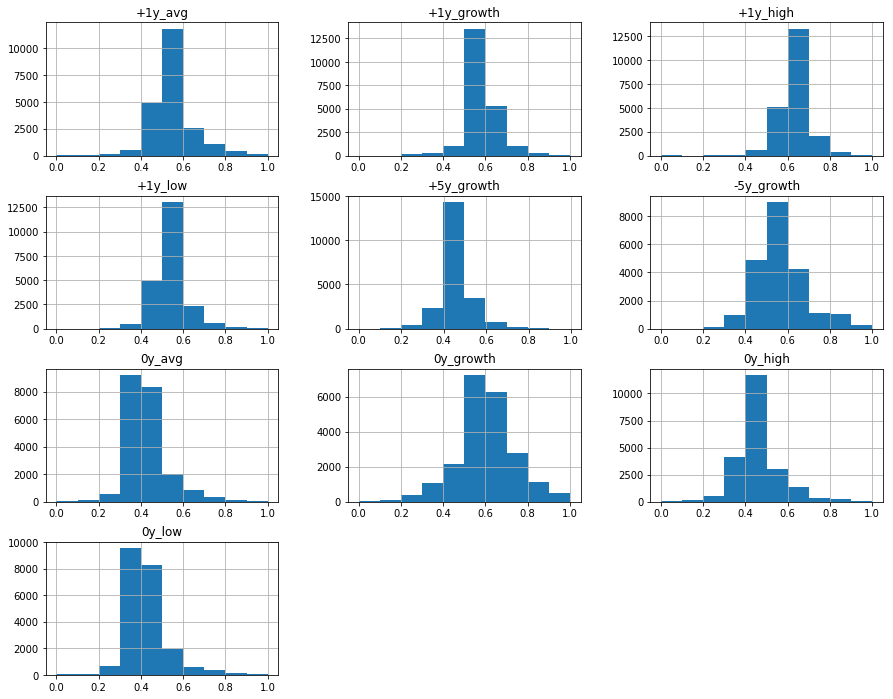

In [20]:
X_train.hist(figsize=(15,12));

In [21]:
%%time
# MLPClassifier
params = {
    'solver': 'lbfgs', 'max_iter': 200, 'activation': 'relu', 
    'alpha': 0.001, 'hidden_layer_sizes': (features - 1, 5),
    'learning_rate': 'adaptive', 'random_state': None, 'verbose': True,}

mlpc = MLPClassifier(**params).fit(X_train, y_train)
scores = mlpc.score(X_train, y_train), mlpc.score(X_test, y_test)
print(scores)

(0.3139083856667898, 0.31560480147737763)
CPU times: user 6.74 s, sys: 982 ms, total: 7.72 s
Wall time: 1.36 s


#### Metrics

Feature ranking:
3 feature +1y_low (0.1264778177375633)
2 feature +1y_high (0.12049460077806336)
9 feature 0y_low (0.10677496863100529)
8 feature 0y_high (0.10581245015996356)
1 feature +1y_growth (0.10179368405130386)
0 feature +1y_avg (0.09874437019378789)
7 feature 0y_growth (0.09106444236163007)
4 feature +5y_growth (0.08782767687447313)
6 feature 0y_avg (0.08346024826945914)
5 feature -5y_growth (0.07754974094275044)


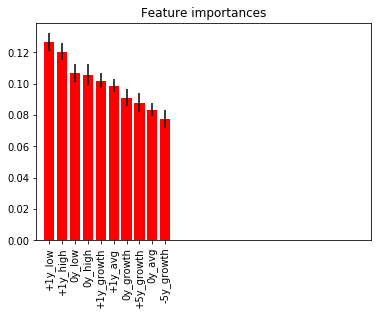

In [23]:
show_fi(rfc, X_train, 25)

In [24]:
print('Confussion Matrix\n', confusion_matrix(rfc.predict(X_test), y_test, labels=fwd_ret_labels))

Confussion Matrix
 [[ 718  198   30   11   11]
 [ 203 1054  259   81   17]
 [  15  226  475  201   19]
 [  21   78  203  927  116]
 [   2   14   18  104  414]]


In [25]:
print('Classificaton report\n', classification_report(rfc.predict(X_test), y_test, target_names=fwd_ret_labels))

Classificaton report
               precision    recall  f1-score   support

        bear       0.75      0.74      0.75       968
       short       0.72      0.75      0.73       552
     neutral       0.70      0.69      0.69      1345
        long       0.48      0.51      0.49       936
        bull       0.67      0.65      0.66      1614

   micro avg       0.66      0.66      0.66      5415
   macro avg       0.66      0.67      0.67      5415
weighted avg       0.66      0.66      0.66      5415



In [26]:
log_loss(y_test, rfc.predict_proba(X_test))

1.883275294345023

#### Gridsearches

In [ ]:
# np.arange(10, X.shape[1], int(X.shape[1]*.25))

In [ ]:
# %%time
# # GridSearchCV for RandomForestClassifier
# parameters = {
#     'n_estimators': [10, 40, 80], 
#     'max_features': np.arange(10, X.shape[1], int(X.shape[1]*.25)), 
#     'random_state': np.arange(1, 10, 3)}

# # parameters = {
# #     'n_estimators': [40], 
# #     'max_features': [30], 
# #     'random_state': [1]}

# clf = GridSearchCV(RandomForestClassifier(), parameters, n_jobs=-1, cv=5)
# clf.fit(X_train, y_train)

# print(clf.score(X_train, y_train), clf.score(X_test, y_test))
# print(clf.best_params_)

In [ ]:
# %%time
# # GridSearchCV for MLPClassifier

# parameters = {
#     'solver': ['lbfgs'], # ['lbfgs', 'sgd', 'adam']
#     'max_iter': [200], # [200, 400, 600]
#     'activation': ['relu'], # ['logistic', 'tanh', 'relu']
#     'alpha': 10.0 ** -np.arange(2, 5, 1), # 10.0 ** -np.arange(2, 5, 1)
#     'learning_rate' : ['adaptive'], # ['constant', 'adaptive']
#     'hidden_layer_sizes': np.arange(5, 50, 10), # np.arange(5, 50, 10)
#     'random_state': np.arange(0, 10, 3)} # np.arange(0, 10, 2)

# parameters = {
#     'solver': ['lbfgs'], 
#     'max_iter': [200], 
#     'activation': ['relu'], 
#     'alpha': [0.01], 
#     'learning_rate' : ['adaptive'], # ['constant', 'adaptive']
#     'hidden_layer_sizes': [ 45 ], # np.arange(5, 50, 10)
#     'random_state': [0] } # np.arange(0, 10, 2)

# clf = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1, cv=5)
# clf.fit(X_train, y_train)

# scores = clf.score(X_train, y_train), clf.score(X_test, y_test)
# print(scores)
# print(clf.best_params_)